In [1]:
!pip install scikit-video

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.4 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import skvideo.io
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


In [ ]:
!git clone https://github.com/seymanurakti/fight-detection-surv-dataset.git

Cloning into 'fight-detection-surv-dataset'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 84.35 MiB | 30.88 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:

np.float = np.float64
np.int = np.int_

In [ ]:
def frame_crop_center(video,cropf):
    f,_,_,_ = video.shape
    startf = f//2 - cropf//2
    return video[startf:startf+cropf, :, :, :]

fights=[]
nofights=[]

surv_fights=[]
surv_no_fights=[]

video_dims = []

####### Fight data
for filename in os.listdir('/content/fight-detection-surv-dataset/fight'):
    f = os.path.join('/content/fight-detection-surv-dataset/fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]

    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)

    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)

    fights.append(video)

for filename in os.listdir('/content/fight-detection-surv-dataset/fight'):
    f = os.path.join('/content/fight-detection-surv-dataset/fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_fights.append(video)

####### Non Fight data
for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
    f = os.path.join('/content/fight-detection-surv-dataset/noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    nofights.append(video)

for filename in os.listdir('/content/fight-detection-surv-dataset/noFight'):
    f = os.path.join('/content/fight-detection-surv-dataset/noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_no_fights.append(video)

In [ ]:
data= pd.DataFrame(video_dims, columns=['frame_length', 'height', 'width', 'channels'])
data.describe()

,frame_length,height,width,channels
count,600.000000,600.000000,600.000000,600.0
mean,57.066667,467.466667,789.006667,3.0
std,15.919525,200.363098,382.745499,0.0
min,20.000000,216.000000,320.000000,3.0
25%,50.000000,360.000000,480.000000,3.0
50%,60.000000,360.000000,640.000000,3.0
75%,60.000000,720.000000,1280.000000,3.0
max,142.000000,1080.000000,1920.000000,3.0


In [ ]:
surv_fights = [video for video in surv_fights if video.shape[0] == 42]
surv_no_fights = [video for video in surv_no_fights if video.shape[0] == 42]

fights = [video for video in fights if video.shape[0] == 42]
nofights = [video for video in nofights if video.shape[0] == 42]
videos = fights + surv_fights + nofights + surv_no_fights
videos = np.asarray(videos)

labels = np.concatenate([np.ones(len(fights)+len(surv_fights)) , np.zeros(len(nofights)+len(surv_no_fights))])

In [ ]:
del fights
del nofights
del surv_fights
del surv_no_fights

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=2334)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=124567)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(374, 42, 128, 128, 3)
(42, 42, 128, 128, 3)
(104, 42, 128, 128, 3)


In [ ]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA
DATASET_NAME = "fight/nofights"
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42, 128, 128, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 100

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2

In [ ]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels"""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )

    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare dataloader"""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader

X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
trainloader = prepare_dataloader(X_train_shuffled, y_train_shuffled, "train")
validloader = prepare_dataloader(X_val, y_val, "valid")
testloader = prepare_dataloader(X_test, y_test, "test")

In [ ]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [ ]:

weights = {}
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output, weights['attention_score'] = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1,return_attention_scores=True)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Epoch 1/100
94/94 [==============================] - 15s 46ms/step - loss: 0.7548 - accuracy: 0.5214 - recall_m: 0.9894 - precision_m: 0.5426 - f1_m: 0.6786 - val_loss: 0.6927 - val_accuracy: 0.5000 - val_recall_m: 0.9091 - val_precision_m: 0.5455 - val_f1_m: 0.6528
Epoch 2/100
94/94 [==============================] - 4s 40ms/step - loss: 0.7127 - accuracy: 0.5027 - recall_m: 0.9681 - precision_m: 0.5399 - f1_m: 0.6672 - val_loss: 0.7165 - val_accuracy: 0.4524 - val_recall_m: 0.9091 - val_precision_m: 0.5455 - val_f1_m: 0.6528
Epoch 3/100
94/94 [==============================] - 4s 40ms/step - loss: 0.7014 - accuracy: 0.5401 - recall_m: 0.9681 - precision_m: 0.5399 - f1_m: 0.6729 - val_loss: 0.6884 - val_accuracy: 0.5476 - val_recall_m: 0.9091 - val_precision_m: 0.5455 - val_f1_m: 0.6528
Epoch 4/100
94/94 [==============================] - 4s 43ms/step - loss: 0.7072 - accuracy: 0.5374 - recall_m: 0.9468 - precision_m: 0.5399 - f1_m: 0.6647 - val_loss: 0.6908 - val_accuracy: 0.5476 - v

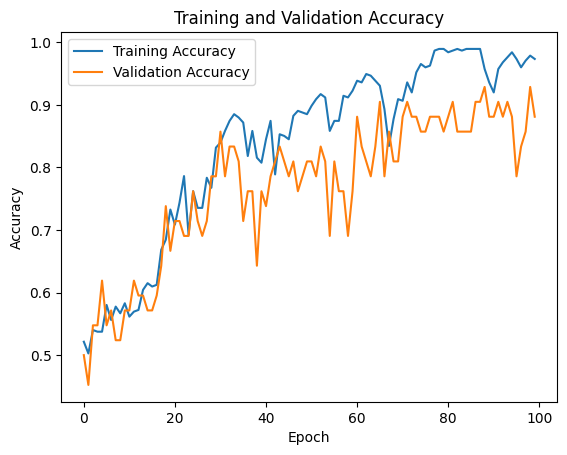

26/26 [==============================] - 1s 18ms/step - loss: 0.5133 - accuracy: 0.9423 - recall_m: 0.8846 - precision_m: 0.4904 - f1_m: 0.6015
Test accuracy: 94.23%
Test recall: 88.46%
Test precision: 49.04%
Test F1: 60.15%


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            recall_m,
            precision_m,
            f1_m,
        ],
    )

    # Train the model.
    history = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)
    # Plot training accuracy and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    _, accuracy, recall, precision, f1 = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")

    vivit_scores = [accuracy, recall, precision, f1]
    return model, vivit_scores


model, vivit_scores = run_experiment()


In [ ]:
prediction =model.predict(testloader)

26/26 [==============================] - 1s 23ms/step


In [ ]:
len(prediction)
y_preds = np.argmax(model.predict(testloader), axis=1)
len(y_preds)

26/26 [==============================] - 1s 22ms/step


104

In [ ]:
for data in testloader:
    first_sample = data[0]
    second_sample = data[1]
    break

In [ ]:
prediction =model.predict(first_sample)

1/1 [==============================] - 0s 62ms/step


In [ ]:
y_preds = np.argmax(prediction, axis=1)

In [ ]:
y_test[3]

1.0

In [ ]:
y_preds

array([0, 0, 1, 1])

26/26 [==============================] - 1s 17ms/step


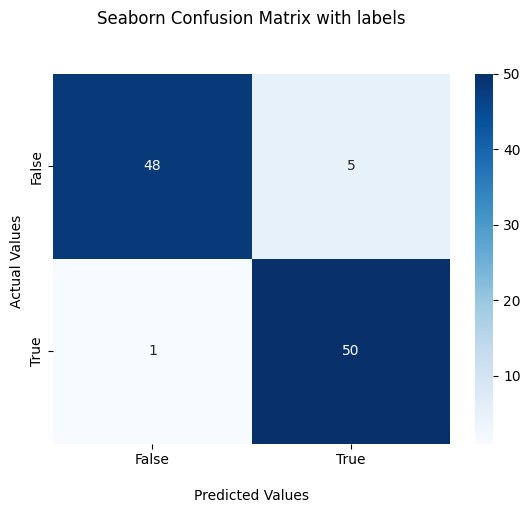

In [ ]:
y_preds = np.argmax(model.predict(testloader), axis=1)
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("vivit_cf.png")